## Problem 2

### Import statements

In [1]:
import numpy as np
import cv2
import matplotlib .pyplot as plt

### Extracting frame 1 and 4 from video

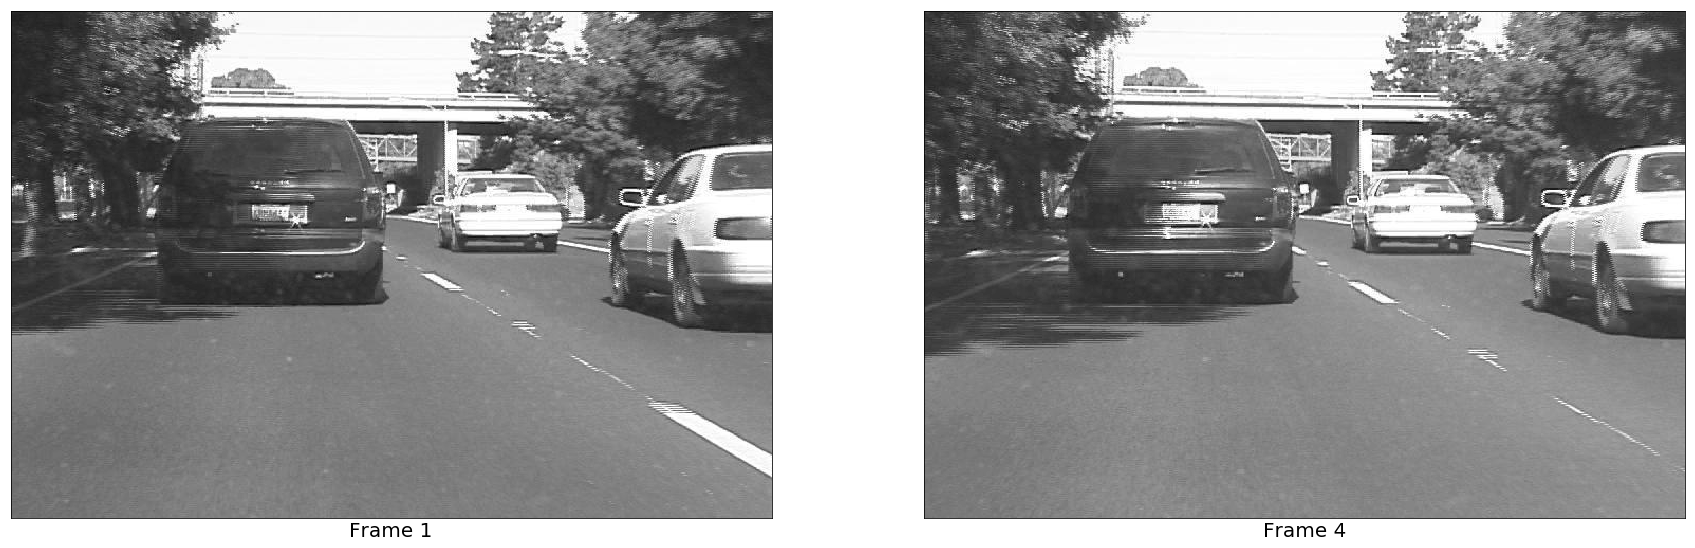

In [2]:
vid = cv2.VideoCapture('./data/Q2.avi')
_, frame1 = vid.read()
_, _ = vid.read()
_, _ = vid.read()
_, frame4 = vid.read()
vid.release()
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame4 = cv2.cvtColor(frame4, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(30, 50))
plt.subplot(1, 2, 1)
plt.imshow(frame1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Frame 1', fontsize=20)
plt.subplot(1, 2, 2)
plt.imshow(frame4, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Frame 4', fontsize=20)
plt.show()

### Finding Harris corner points in both the frames

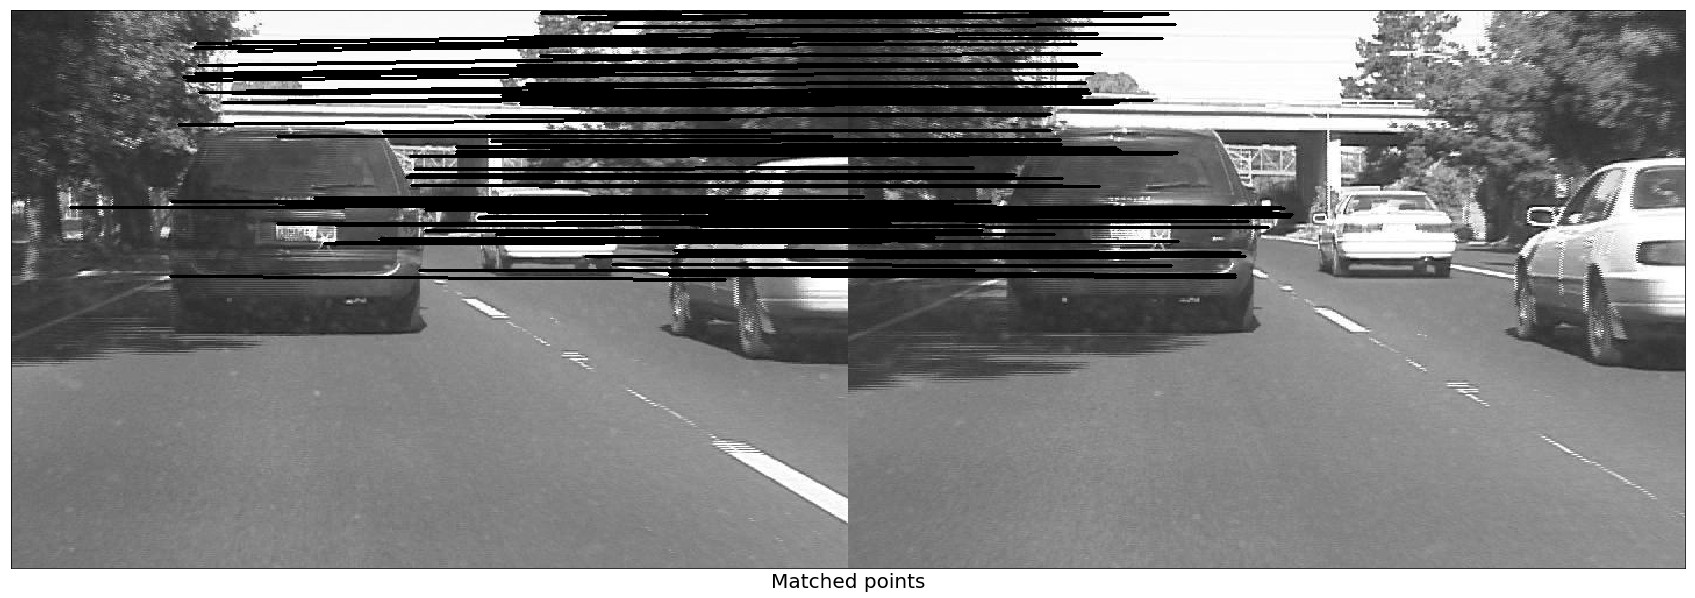

In [3]:
p1 = cv2.goodFeaturesToTrack(frame1, maxCorners = 500, qualityLevel = 0.2, minDistance = 2, useHarrisDetector=True)
p4, st, _ = cv2.calcOpticalFlowPyrLK(frame1, frame4, p1, None)
matched_points1 = p1[st==1].astype(int)
matched_points4 = p4[st==1].astype(int)
large_image = np.concatenate((frame1, frame4), axis=1)
matched_points4 = (matched_points4 + np.array([frame1.shape[0], 0])).astype(int)
matched_points1 = list(zip(matched_points1[:,0], matched_points1[:,1]))
matched_points4= list(zip(matched_points4[:,0], matched_points4[:,1]))
for matched_point1, matched_point4 in zip(matched_points1, matched_points4):
    cv2.line(large_image, matched_point1, matched_point4, (0, 0, 0), 2)
plt.figure(figsize=(30, 50))
plt.imshow(large_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Matched points', fontsize=20)
plt.show()

### Finding homography

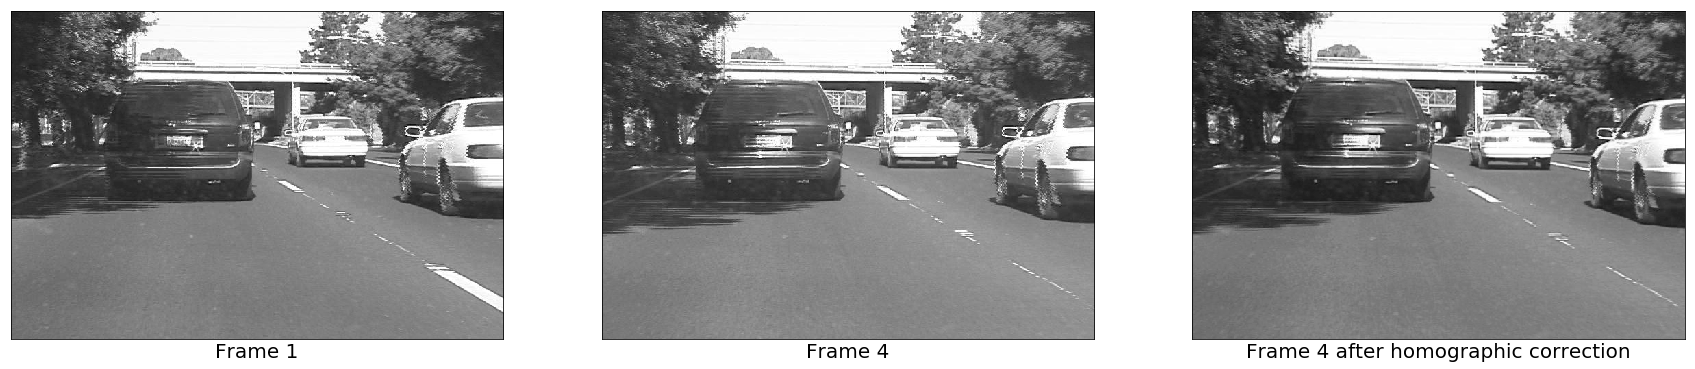

In [4]:
matched_points1 = p1[st==1].astype(int)
matched_points4 = p4[st==1].astype(int)
matched_points1 = np.vstack((matched_points1.T, np.ones((1, matched_points1.T.shape[1]))))
matched_points4 = np.vstack((matched_points4.T, np.ones((1, matched_points4.T.shape[1]))))
m1 = np.mean(matched_points1[:2], axis=1)
max_std1 = max(np.std(matched_points1[:2], axis=1)) + 1e-9
c1 = np.diag([1 / max_std1, 1 / max_std1, 1])
c1[0][2] = -m1[0] / max_std1
c1[1][2] = -m1[1] / max_std1
mp1_n = np.dot(c1, matched_points1)
m4 = np.mean(matched_points4[:2], axis=1)
max_std4 = max(np.std(matched_points4[:2], axis=1)) + 1e-9
c4 = np.diag([1 / max_std4, 1 / max_std4, 1])
c4[0][2] = -m1[0] / max_std4
c4[1][2] = -m1[1] / max_std4
mp4_n = np.dot(c4, matched_points4)
counts = mp1_n.shape[1]
a = np.zeros((2 * counts, 9))
for i in range(counts):
    a[2 * i] = [-mp1_n[0][i], -mp1_n[1][i], -1, 0, 0, 0, mp4_n[0][i] * mp1_n[0][i], mp4_n[0][i] * mp1_n[1][i], mp4_n[0][i]]
    a[2 * i + 1] = [0, 0, 0, -mp1_n[0][i], -mp1_n[1][i], -1, mp4_n[1][i] * mp1_n[0][i], mp4_n[1][i] * mp1_n[1][i], mp4_n[1][i]]
u, s, v = np.linalg.svd(a)
homo_mat = v[8].reshape((3, 3))
homo_mat = np.dot(np.linalg.inv(c4), np.dot(homo_mat, c1))
homo_mat = homo_mat / homo_mat[2, 2]
frame4_warp = cv2.warpPerspective(frame4, homo_mat, frame4.T.shape)
plt.figure(figsize=(30, 50))
plt.subplot(1, 3, 1)
plt.imshow(frame1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Frame 1', fontsize=20)
plt.subplot(1, 3, 2)
plt.imshow(frame4, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Frame 4', fontsize=20)
plt.subplot(1, 3, 3)
plt.imshow(frame4_warp, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Frame 4 after homographic correction', fontsize=20)
plt.show()

### Detecting the moving objects

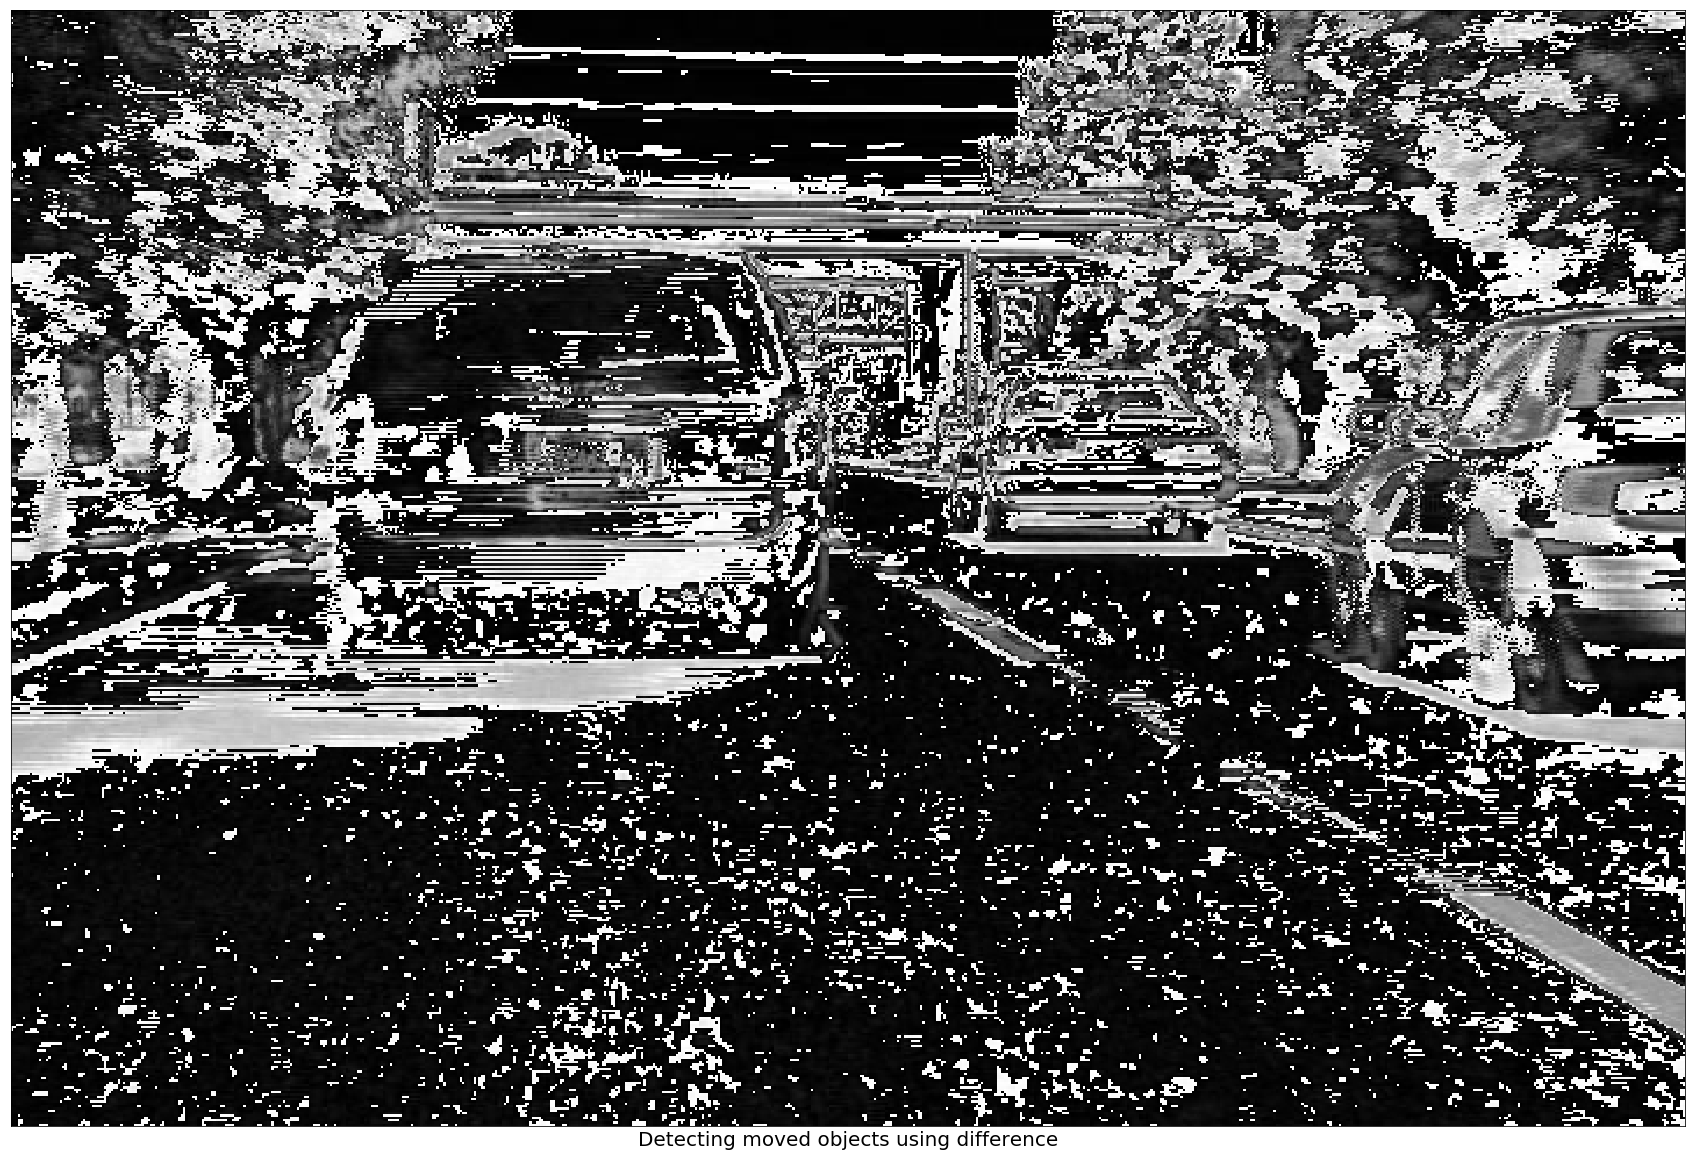

In [5]:
background = frame4_warp - frame1
plt.figure(figsize=(30, 50))
plt.xticks([])
plt.yticks([])
plt.xlabel('Detecting moved objects using difference', fontsize=20)
plt.imshow(background, cmap='gray')
plt.show()

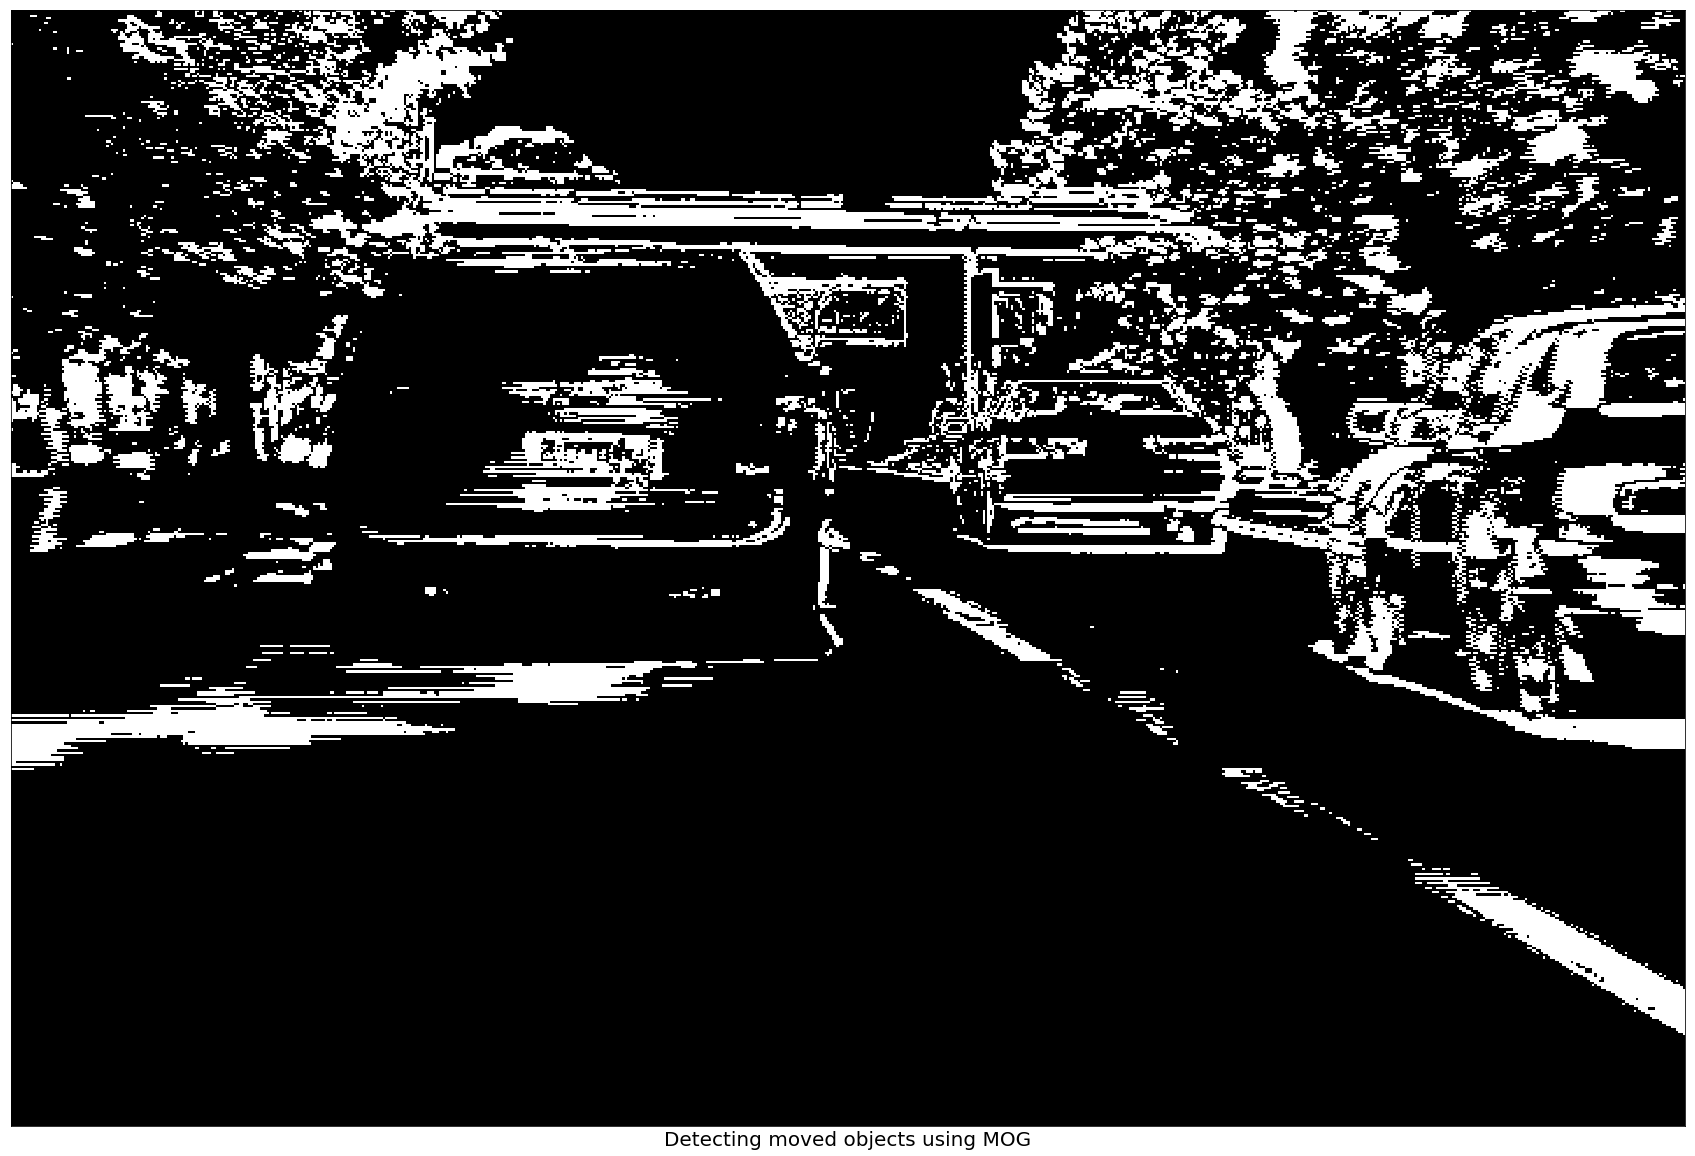

In [6]:
backgroundSubtractor = cv2.createBackgroundSubtractorMOG2(varThreshold=128)
mask = backgroundSubtractor.apply(frame1)
mask = backgroundSubtractor.apply(frame4_warp)
plt.figure(figsize=(30, 50))
plt.xticks([])
plt.yticks([])
plt.xlabel('Detecting moved objects using MOG', fontsize=20)
plt.imshow(mask, cmap='gray')
plt.show()